In [1]:
import sys
sys.path.insert(0, '/media/allen/mass/deep-learning-works/')
import os.path as osp
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from database.dataset_factory import get_dataset
from manager.manager_factory import get_manager

from config.config_factory import _C as cfg
from config.config_factory import build_output

from tools.logger import setup_logger
logger = setup_logger(".")
from tools.utils import deploy_macro

import cv2
from PIL import Image 

def to_pil(cv_img):
    img = cv2.cvtColor(cv_img, cv2.COLOR_BGR2RGB)
    return Image.fromarray(img)

from tools.utils import multi_pose_decode, multi_pose_post_process, _sigmoid

In [2]:
from database.data_factory import get_names as data_names
from database.dataset_factory import get_names as dataset_names
from database.loader_factory import get_names as loader_names
from manager.manager_factory import get_names as manager_names
from engine.engine_factory import get_names as engine_names
print("DATA: ", data_names())
print("DATASET: ", dataset_names())
print("LOADER: ", loader_names())
print("MANAGER: ", manager_names())
print("ENGINE: ", engine_names())

DATA:  ['coco', 'coco_person_kp', 'deepfashion', 'market', 'cuhk01', 'cuhk02', 'cuhk03', 'duke', 'msmt', 'imagenet', 'cifar10']
DATASET:  ['coco_keypoint', 'coco_object', 'reid', 'imagenet', 'cifar10']
LOADER:  ['coco', 'reid', 'imagenet', 'cifar10']
MANAGER:  ['center', 'center_kp', 'imagenet', 'par', 'reid_trick']
ENGINE:  ['center', 'center_kp', 'imagenet', 'par', 'reid_trick']


In [3]:
config_path = '/media/allen/mass/deep-learning-works/config/keypoint.yml'
cfg.merge_from_file(config_path)
cfg.DB.PATH     = '/media/allen/mass/DB/'
cfg.DB.USE_TRAIN = False
cfg.DB.USE_TEST  = True
cfg.MODEL.GPU   = [1]
cfg.MODEL.NORM  = "BN"
cfg.COCO.TARGET = 'original'
cfg.ENGINE      = 'center_kp'
cfg.MANAGER     = 'center_kp'
cfg.DB.DATA     = 'coco_person_kp'
cfg.DB.DATASET  = 'coco_keypoint'
cfg.DB.LOADER   = 'coco'
cfg.DB.NUM_CLASSES   = 1
cfg.DB.NUM_KEYPOINTS = 17
cfg.EVALUATE         = '../caffe_models/Hourglass-Squeeze_coco_person_kp_focal_regl1_regwl1_Adam_lr_0.0005_plateau_10_coco_0.4303.pth'
deploy_macro(cfg)

2019-12-23 08:55:21,133 logger INFO: Using GPU: 1


In [4]:
preprocessor = get_dataset(cfg.DB.DATASET).preprocess
MEAN = get_dataset(cfg.DB.DATASET).mean
STD = get_dataset(cfg.DB.DATASET).std

In [6]:
manager = get_manager(cfg.MANAGER)(cfg)
manager.use_multigpu()
model = manager.model
model.eval()
print("")

2019-12-23 08:55:42,774 logger INFO: Evaluating model from ../caffe_models/Hourglass-Squeeze_coco_person_kp_focal_regl1_regwl1_Adam_lr_0.0005_plateau_10_coco_0.4303.pth
2019-12-23 08:55:45,173 logger INFO: Using GPU: 1
2019-12-23 08:55:45,175 logger INFO: Use Single-GPU



In [6]:
manager.check_size((1,3,512,512))

2019-12-20 10:11:11,039 logger INFO: backbone.pre.0.conv                                         
2019-12-20 10:11:11,041 logger INFO:              input,   1 x   3 x 512 x 512
2019-12-20 10:11:11,041 logger INFO:             output,   1 x 128 x 256 x 256
2019-12-20 10:11:11,050 logger INFO: backbone.pre.0.bn.0                                         
2019-12-20 10:11:11,054 logger INFO:              input,   1 x 128 x 256 x 256
2019-12-20 10:11:11,055 logger INFO:             output,   1 x 128 x 256 x 256
2019-12-20 10:11:11,061 logger INFO: backbone.pre.0.bn.1                                         
2019-12-20 10:11:11,062 logger INFO:              input,   1 x 128 x 256 x 256
2019-12-20 10:11:11,063 logger INFO:             output,   1 x 128 x 256 x 256
2019-12-20 10:11:11,064 logger INFO: backbone.pre.0.bn                                           
2019-12-20 10:11:11,065 logger INFO:              input,   1 x 128 x 256 x 256
2019-12-20 10:11:11,066 logger INFO:             output

2019-12-20 10:11:11,527 logger INFO:              input,   1 x 256 x  64 x  64
2019-12-20 10:11:11,527 logger INFO:             output,   1 x 256 x  64 x  64
2019-12-20 10:11:11,529 logger INFO: backbone.hg_mods.0.up1.0.relu                               
2019-12-20 10:11:11,530 logger INFO:              input,   1 x 256 x  64 x  64
2019-12-20 10:11:11,531 logger INFO:             output,   1 x 256 x  64 x  64
2019-12-20 10:11:11,532 logger INFO: backbone.hg_mods.0.up1.0                                    
2019-12-20 10:11:11,533 logger INFO:              input,   1 x 256 x  64 x  64
2019-12-20 10:11:11,533 logger INFO:             output,   1 x 256 x  64 x  64
2019-12-20 10:11:11,535 logger INFO: backbone.hg_mods.0.up1.1.conv1                              
2019-12-20 10:11:11,536 logger INFO:              input,   1 x 256 x  64 x  64
2019-12-20 10:11:11,537 logger INFO:             output,   1 x 128 x  64 x  64
2019-12-20 10:11:11,538 logger INFO: backbone.hg_mods.0.up1.1.bn1         

2019-12-20 10:11:11,635 logger INFO:             output,   1 x 256 x  32 x  32
2019-12-20 10:11:11,636 logger INFO: backbone.hg_mods.0.low2.up1.0.relu                          
2019-12-20 10:11:11,637 logger INFO:              input,   1 x 256 x  32 x  32
2019-12-20 10:11:11,638 logger INFO:             output,   1 x 256 x  32 x  32
2019-12-20 10:11:11,639 logger INFO: backbone.hg_mods.0.low2.up1.0                               
2019-12-20 10:11:11,640 logger INFO:              input,   1 x 256 x  32 x  32
2019-12-20 10:11:11,641 logger INFO:             output,   1 x 256 x  32 x  32
2019-12-20 10:11:11,642 logger INFO: backbone.hg_mods.0.low2.up1.1.conv1                         
2019-12-20 10:11:11,643 logger INFO:              input,   1 x 256 x  32 x  32
2019-12-20 10:11:11,644 logger INFO:             output,   1 x 128 x  32 x  32
2019-12-20 10:11:11,646 logger INFO: backbone.hg_mods.0.low2.up1.1.bn1                           
2019-12-20 10:11:11,647 logger INFO:              input

2019-12-20 10:11:11,739 logger INFO: backbone.hg_mods.0.low2.low2.up1.0.relu                     
2019-12-20 10:11:11,740 logger INFO:              input,   1 x 384 x  16 x  16
2019-12-20 10:11:11,740 logger INFO:             output,   1 x 384 x  16 x  16
2019-12-20 10:11:11,741 logger INFO: backbone.hg_mods.0.low2.low2.up1.0                          
2019-12-20 10:11:11,741 logger INFO:              input,   1 x 384 x  16 x  16
2019-12-20 10:11:11,742 logger INFO:             output,   1 x 384 x  16 x  16
2019-12-20 10:11:11,743 logger INFO: backbone.hg_mods.0.low2.low2.up1.1.conv1                    
2019-12-20 10:11:11,743 logger INFO:              input,   1 x 384 x  16 x  16
2019-12-20 10:11:11,744 logger INFO:             output,   1 x 192 x  16 x  16
2019-12-20 10:11:11,745 logger INFO: backbone.hg_mods.0.low2.low2.up1.1.bn1                      
2019-12-20 10:11:11,745 logger INFO:              input,   1 x 192 x  16 x  16
2019-12-20 10:11:11,746 logger INFO:             output

2019-12-20 10:11:11,844 logger INFO:              input,   1 x 384 x   8 x   8
2019-12-20 10:11:11,844 logger INFO:             output,   1 x 384 x   8 x   8
2019-12-20 10:11:11,845 logger INFO: backbone.hg_mods.0.low2.low2.low2.up1.0                     
2019-12-20 10:11:11,845 logger INFO:              input,   1 x 384 x   8 x   8
2019-12-20 10:11:11,847 logger INFO:             output,   1 x 384 x   8 x   8
2019-12-20 10:11:11,848 logger INFO: backbone.hg_mods.0.low2.low2.low2.up1.1.conv1               
2019-12-20 10:11:11,849 logger INFO:              input,   1 x 384 x   8 x   8
2019-12-20 10:11:11,849 logger INFO:             output,   1 x 192 x   8 x   8
2019-12-20 10:11:11,852 logger INFO: backbone.hg_mods.0.low2.low2.low2.up1.1.bn1                 
2019-12-20 10:11:11,858 logger INFO:              input,   1 x 192 x   8 x   8
2019-12-20 10:11:11,859 logger INFO:             output,   1 x 192 x   8 x   8
2019-12-20 10:11:11,860 logger INFO: backbone.hg_mods.0.low2.low2.low2.up1

2019-12-20 10:11:11,967 logger INFO:             output,   1 x 512 x   4 x   4
2019-12-20 10:11:11,968 logger INFO: backbone.hg_mods.0.low2.low2.low2.low2.0                    
2019-12-20 10:11:11,969 logger INFO:              input,   1 x 512 x   4 x   4
2019-12-20 10:11:11,969 logger INFO:             output,   1 x 512 x   4 x   4
2019-12-20 10:11:11,970 logger INFO: backbone.hg_mods.0.low2.low2.low2.low2.1.conv1              
2019-12-20 10:11:11,971 logger INFO:              input,   1 x 512 x   4 x   4
2019-12-20 10:11:11,972 logger INFO:             output,   1 x 256 x   4 x   4
2019-12-20 10:11:11,973 logger INFO: backbone.hg_mods.0.low2.low2.low2.low2.1.bn1                
2019-12-20 10:11:11,974 logger INFO:              input,   1 x 256 x   4 x   4
2019-12-20 10:11:11,975 logger INFO:             output,   1 x 256 x   4 x   4
2019-12-20 10:11:11,976 logger INFO: backbone.hg_mods.0.low2.low2.low2.low2.1.conv_1x1           
2019-12-20 10:11:11,977 logger INFO:              input

2019-12-20 10:11:12,089 logger INFO: backbone.hg_mods.0.low2.low2.low2.low3.1.conv_1x1           
2019-12-20 10:11:12,090 logger INFO:              input,   1 x 192 x   4 x   4
2019-12-20 10:11:12,091 logger INFO:             output,   1 x 192 x   4 x   4
2019-12-20 10:11:12,110 logger INFO: backbone.hg_mods.0.low2.low2.low2.low3.1.conv_3x3           
2019-12-20 10:11:12,111 logger INFO:              input,   1 x 192 x   4 x   4
2019-12-20 10:11:12,117 logger INFO:             output,   1 x 192 x   4 x   4
2019-12-20 10:11:12,120 logger INFO: backbone.hg_mods.0.low2.low2.low2.low3.1.bn2.0              
2019-12-20 10:11:12,122 logger INFO:              input,   1 x 384 x   4 x   4
2019-12-20 10:11:12,123 logger INFO:             output,   1 x 384 x   4 x   4
2019-12-20 10:11:12,124 logger INFO: backbone.hg_mods.0.low2.low2.low2.low3.1.bn2.1              
2019-12-20 10:11:12,125 logger INFO:              input,   1 x 384 x   4 x   4
2019-12-20 10:11:12,126 logger INFO:             output

2019-12-20 10:11:12,290 logger INFO:             output,   1 x 192 x  16 x  16
2019-12-20 10:11:12,292 logger INFO: backbone.hg_mods.0.low2.low3.0.bn2                          
2019-12-20 10:11:12,293 logger INFO:              input,   1 x 384 x  16 x  16
2019-12-20 10:11:12,293 logger INFO:             output,   1 x 384 x  16 x  16
2019-12-20 10:11:12,295 logger INFO: backbone.hg_mods.0.low2.low3.0.relu                         
2019-12-20 10:11:12,296 logger INFO:              input,   1 x 384 x  16 x  16
2019-12-20 10:11:12,297 logger INFO:             output,   1 x 384 x  16 x  16
2019-12-20 10:11:12,298 logger INFO: backbone.hg_mods.0.low2.low3.0                              
2019-12-20 10:11:12,299 logger INFO:              input,   1 x 384 x  16 x  16
2019-12-20 10:11:12,300 logger INFO:             output,   1 x 384 x  16 x  16
2019-12-20 10:11:12,306 logger INFO: backbone.hg_mods.0.low2.low3.1.conv1                        
2019-12-20 10:11:12,307 logger INFO:              input

2019-12-20 10:11:12,475 logger INFO:              input,   1 x 256 x  64 x  64
2019-12-20 10:11:12,475 logger INFO:             output,   1 x 256 x  64 x  64
2019-12-20 10:11:12,476 logger INFO: backbone.hg_mods.0                                          
2019-12-20 10:11:12,477 logger INFO:              input,   1 x 256 x  64 x  64
2019-12-20 10:11:12,478 logger INFO:             output,   1 x 256 x  64 x  64
2019-12-20 10:11:12,486 logger INFO: backbone.cnvs.0.conv                                        
2019-12-20 10:11:12,489 logger INFO:              input,   1 x 256 x  64 x  64
2019-12-20 10:11:12,491 logger INFO:             output,   1 x 256 x  64 x  64
2019-12-20 10:11:12,494 logger INFO: backbone.cnvs.0.bn.0                                        
2019-12-20 10:11:12,496 logger INFO:              input,   1 x 256 x  64 x  64
2019-12-20 10:11:12,497 logger INFO:             output,   1 x 256 x  64 x  64
2019-12-20 10:11:12,499 logger INFO: backbone.cnvs.0.bn.1                 

2019-12-20 10:11:12,679 logger INFO:             output,   1 x 256 x  64 x  64
2019-12-20 10:11:12,680 logger INFO: backbone.hp_reg.0.0.bn                                      
2019-12-20 10:11:12,681 logger INFO:              input,   1 x 256 x  64 x  64
2019-12-20 10:11:12,681 logger INFO:             output,   1 x 256 x  64 x  64
2019-12-20 10:11:12,682 logger INFO: backbone.hp_reg.0.0                                         
2019-12-20 10:11:12,682 logger INFO:              input,   1 x 256 x  64 x  64
2019-12-20 10:11:12,683 logger INFO:             output,   1 x 256 x  64 x  64
2019-12-20 10:11:12,684 logger INFO: backbone.hp_reg.0.1                                         
2019-12-20 10:11:12,685 logger INFO:              input,   1 x 256 x  64 x  64
2019-12-20 10:11:12,686 logger INFO:             output,   1 x   2 x  64 x  64
2019-12-20 10:11:12,686 logger INFO: backbone.hp_reg.0                                           
2019-12-20 10:11:12,687 logger INFO:              input

2019-12-20 10:11:12,795 logger INFO: backbone.hg_mods.1.up1.1.relu                               
2019-12-20 10:11:12,795 logger INFO:              input,   1 x 256 x  64 x  64
2019-12-20 10:11:12,796 logger INFO:             output,   1 x 256 x  64 x  64
2019-12-20 10:11:12,796 logger INFO: backbone.hg_mods.1.up1.1                                    
2019-12-20 10:11:12,797 logger INFO:              input,   1 x 256 x  64 x  64
2019-12-20 10:11:12,798 logger INFO:             output,   1 x 256 x  64 x  64
2019-12-20 10:11:12,799 logger INFO: backbone.hg_mods.1.up1                                      
2019-12-20 10:11:12,799 logger INFO:              input,   1 x 256 x  64 x  64
2019-12-20 10:11:12,800 logger INFO:             output,   1 x 256 x  64 x  64
2019-12-20 10:11:12,802 logger INFO: backbone.hg_mods.1.max1                                     
2019-12-20 10:11:12,802 logger INFO:              input,   1 x 256 x  64 x  64
2019-12-20 10:11:12,803 logger INFO:             output

2019-12-20 10:11:12,890 logger INFO:              input,   1 x 256 x  32 x  32
2019-12-20 10:11:12,891 logger INFO:             output,   1 x 256 x  32 x  32
2019-12-20 10:11:12,893 logger INFO: backbone.hg_mods.1.low2.up1.1                               
2019-12-20 10:11:12,894 logger INFO:              input,   1 x 256 x  32 x  32
2019-12-20 10:11:12,895 logger INFO:             output,   1 x 256 x  32 x  32
2019-12-20 10:11:12,896 logger INFO: backbone.hg_mods.1.low2.up1                                 
2019-12-20 10:11:12,897 logger INFO:              input,   1 x 256 x  32 x  32
2019-12-20 10:11:12,898 logger INFO:             output,   1 x 256 x  32 x  32
2019-12-20 10:11:12,899 logger INFO: backbone.hg_mods.1.low2.max1                                
2019-12-20 10:11:12,899 logger INFO:              input,   1 x 256 x  32 x  32
2019-12-20 10:11:12,900 logger INFO:             output,   1 x 256 x  32 x  32
2019-12-20 10:11:12,902 logger INFO: backbone.hg_mods.1.low2.low1.0.conv1 

2019-12-20 10:11:12,987 logger INFO:             output,   1 x 384 x  16 x  16
2019-12-20 10:11:12,987 logger INFO: backbone.hg_mods.1.low2.low2.up1.1                          
2019-12-20 10:11:12,988 logger INFO:              input,   1 x 384 x  16 x  16
2019-12-20 10:11:12,989 logger INFO:             output,   1 x 384 x  16 x  16
2019-12-20 10:11:12,991 logger INFO: backbone.hg_mods.1.low2.low2.up1                            
2019-12-20 10:11:12,992 logger INFO:              input,   1 x 384 x  16 x  16
2019-12-20 10:11:12,992 logger INFO:             output,   1 x 384 x  16 x  16
2019-12-20 10:11:12,994 logger INFO: backbone.hg_mods.1.low2.low2.max1                           
2019-12-20 10:11:12,995 logger INFO:              input,   1 x 384 x  16 x  16
2019-12-20 10:11:12,996 logger INFO:             output,   1 x 384 x  16 x  16
2019-12-20 10:11:12,997 logger INFO: backbone.hg_mods.1.low2.low2.low1.0.conv1                   
2019-12-20 10:11:12,998 logger INFO:              input

2019-12-20 10:11:13,082 logger INFO: backbone.hg_mods.1.low2.low2.low2.up1.1                     
2019-12-20 10:11:13,082 logger INFO:              input,   1 x 384 x   8 x   8
2019-12-20 10:11:13,084 logger INFO:             output,   1 x 384 x   8 x   8
2019-12-20 10:11:13,085 logger INFO: backbone.hg_mods.1.low2.low2.low2.up1                       
2019-12-20 10:11:13,086 logger INFO:              input,   1 x 384 x   8 x   8
2019-12-20 10:11:13,087 logger INFO:             output,   1 x 384 x   8 x   8
2019-12-20 10:11:13,087 logger INFO: backbone.hg_mods.1.low2.low2.low2.max1                      
2019-12-20 10:11:13,089 logger INFO:              input,   1 x 384 x   8 x   8
2019-12-20 10:11:13,089 logger INFO:             output,   1 x 384 x   8 x   8
2019-12-20 10:11:13,090 logger INFO: backbone.hg_mods.1.low2.low2.low2.low1.0.conv1              
2019-12-20 10:11:13,091 logger INFO:              input,   1 x 384 x   8 x   8
2019-12-20 10:11:13,091 logger INFO:             output

2019-12-20 10:11:13,187 logger INFO:              input,   1 x 512 x   4 x   4
2019-12-20 10:11:13,188 logger INFO:             output,   1 x 512 x   4 x   4
2019-12-20 10:11:13,189 logger INFO: backbone.hg_mods.1.low2.low2.low2.low2.2.conv1              
2019-12-20 10:11:13,190 logger INFO:              input,   1 x 512 x   4 x   4
2019-12-20 10:11:13,191 logger INFO:             output,   1 x 256 x   4 x   4
2019-12-20 10:11:13,192 logger INFO: backbone.hg_mods.1.low2.low2.low2.low2.2.bn1                
2019-12-20 10:11:13,192 logger INFO:              input,   1 x 256 x   4 x   4
2019-12-20 10:11:13,193 logger INFO:             output,   1 x 256 x   4 x   4
2019-12-20 10:11:13,194 logger INFO: backbone.hg_mods.1.low2.low2.low2.low2.2.conv_1x1           
2019-12-20 10:11:13,194 logger INFO:              input,   1 x 256 x   4 x   4
2019-12-20 10:11:13,195 logger INFO:             output,   1 x 256 x   4 x   4
2019-12-20 10:11:13,196 logger INFO: backbone.hg_mods.1.low2.low2.low2.low

2019-12-20 10:11:13,267 logger INFO:             output,   1 x 384 x   8 x   8
2019-12-20 10:11:13,269 logger INFO: backbone.hg_mods.1.low2.low2.low2.merg                      
2019-12-20 10:11:13,269 logger INFO:              input,   1 x 384 x   8 x   8
2019-12-20 10:11:13,270 logger INFO:              input,   1 x 384 x   8 x   8
2019-12-20 10:11:13,271 logger INFO:             output,   1 x 384 x   8 x   8
2019-12-20 10:11:13,272 logger INFO: backbone.hg_mods.1.low2.low2.low2                           
2019-12-20 10:11:13,273 logger INFO:              input,   1 x 384 x   8 x   8
2019-12-20 10:11:13,274 logger INFO:             output,   1 x 384 x   8 x   8
2019-12-20 10:11:13,276 logger INFO: backbone.hg_mods.1.low2.low2.low3.0.conv1                   
2019-12-20 10:11:13,276 logger INFO:              input,   1 x 384 x   8 x   8
2019-12-20 10:11:13,277 logger INFO:             output,   1 x 192 x   8 x   8
2019-12-20 10:11:13,280 logger INFO: backbone.hg_mods.1.low2.low2.low3.0.b

2019-12-20 10:11:13,363 logger INFO:              input,   1 x 256 x  16 x  16
2019-12-20 10:11:13,363 logger INFO:             output,   1 x 256 x  16 x  16
2019-12-20 10:11:13,365 logger INFO: backbone.hg_mods.1.low2.low3.1.bn2.1                        
2019-12-20 10:11:13,365 logger INFO:              input,   1 x 256 x  16 x  16
2019-12-20 10:11:13,366 logger INFO:             output,   1 x 256 x  16 x  16
2019-12-20 10:11:13,367 logger INFO: backbone.hg_mods.1.low2.low3.1.bn2                          
2019-12-20 10:11:13,367 logger INFO:              input,   1 x 256 x  16 x  16
2019-12-20 10:11:13,368 logger INFO:             output,   1 x 256 x  16 x  16
2019-12-20 10:11:13,368 logger INFO: backbone.hg_mods.1.low2.low3.1                              
2019-12-20 10:11:13,369 logger INFO:              input,   1 x 384 x  16 x  16
2019-12-20 10:11:13,370 logger INFO:             output,   1 x 256 x  16 x  16
2019-12-20 10:11:13,371 logger INFO: backbone.hg_mods.1.low2.low3         

2019-12-20 10:11:13,478 logger INFO: backbone.hm.1.0.bn                                          
2019-12-20 10:11:13,479 logger INFO:              input,   1 x 256 x  64 x  64
2019-12-20 10:11:13,480 logger INFO:             output,   1 x 256 x  64 x  64
2019-12-20 10:11:13,481 logger INFO: backbone.hm.1.0                                             
2019-12-20 10:11:13,481 logger INFO:              input,   1 x 256 x  64 x  64
2019-12-20 10:11:13,482 logger INFO:             output,   1 x 256 x  64 x  64
2019-12-20 10:11:13,484 logger INFO: backbone.hm.1.1                                             
2019-12-20 10:11:13,484 logger INFO:              input,   1 x 256 x  64 x  64
2019-12-20 10:11:13,485 logger INFO:             output,   1 x   1 x  64 x  64
2019-12-20 10:11:13,486 logger INFO: backbone.hm.1                                               
2019-12-20 10:11:13,488 logger INFO:              input,   1 x 256 x  64 x  64
2019-12-20 10:11:13,489 logger INFO:             output

In [83]:
edges = [[5, 6], 
        [5, 7], [7, 9], [6, 8], [8, 10], 
        [6, 12], [5, 11], [11, 12], 
        [12, 14], [14, 16], [11, 13], [13, 15]]

In [119]:
path = "/media/allen/mass/office/office_valid/CAM1-2019-11-12_13-08-20_39927.jpg"
img = cv2.imread(path)
batch = preprocessor(img, [1.0], (512,512))

In [120]:
inputs = torch.Tensor(batch['inputs']).cuda()
with torch.no_grad():
    out = model(inputs)
feat = out[-1]
feat['hm'] = _sigmoid(feat['hm'])
feat['hm_hp'] = _sigmoid(feat['hm_hp'])

In [121]:
dets = multi_pose_decode(feat['hm'], feat['wh'], feat['hps'], 
                         reg=feat['reg'], hm_hp=feat['hm_hp'], hp_offset=feat['hp_reg'], K=100)
dets = dets.detach().cpu().numpy().reshape(1, -1, dets.shape[2])    
dets_out = multi_pose_post_process(dets.copy(), batch['c'], batch['s'],
                                   feat['hm'].shape[2], feat['hm'].shape[3], feat['hm'].shape[1])

In [122]:
np_img = img.copy()
for cls in dets_out[0].keys():
    for bbox in dets_out[0][cls]:
        x1, y1, x2, y2 = bbox[:4]
        pts = np.array(bbox[5:]).reshape(-1, 2)
        score = bbox[4]
        if score > 0.5:
            if x1 < 0:
                x1 = 0
            if y1 < 0:
                y1 = 0
            cv2.rectangle(np_img, (int(x1), int(y1)), (int(x2), int(y2)), (255,255,255), 2)
            for (start, end) in edges:                
                cv2.line(np_img, (int(pts[start][0]), int(pts[start][1])), (int(pts[end][0]), int(pts[end][1])),
                         (0,255,255), 2)
            for i, pt in enumerate(pts[5:]):
                cv2.circle(np_img, (int(pt[0]), int(pt[1])), 3, (0,0,255), 3)
#                 cv2.putText(np_img, str(i), (int(pt[0]), int(pt[1])), cv2.FONT_HERSHEY_DUPLEX, 1, (0,0,255), 2)
            

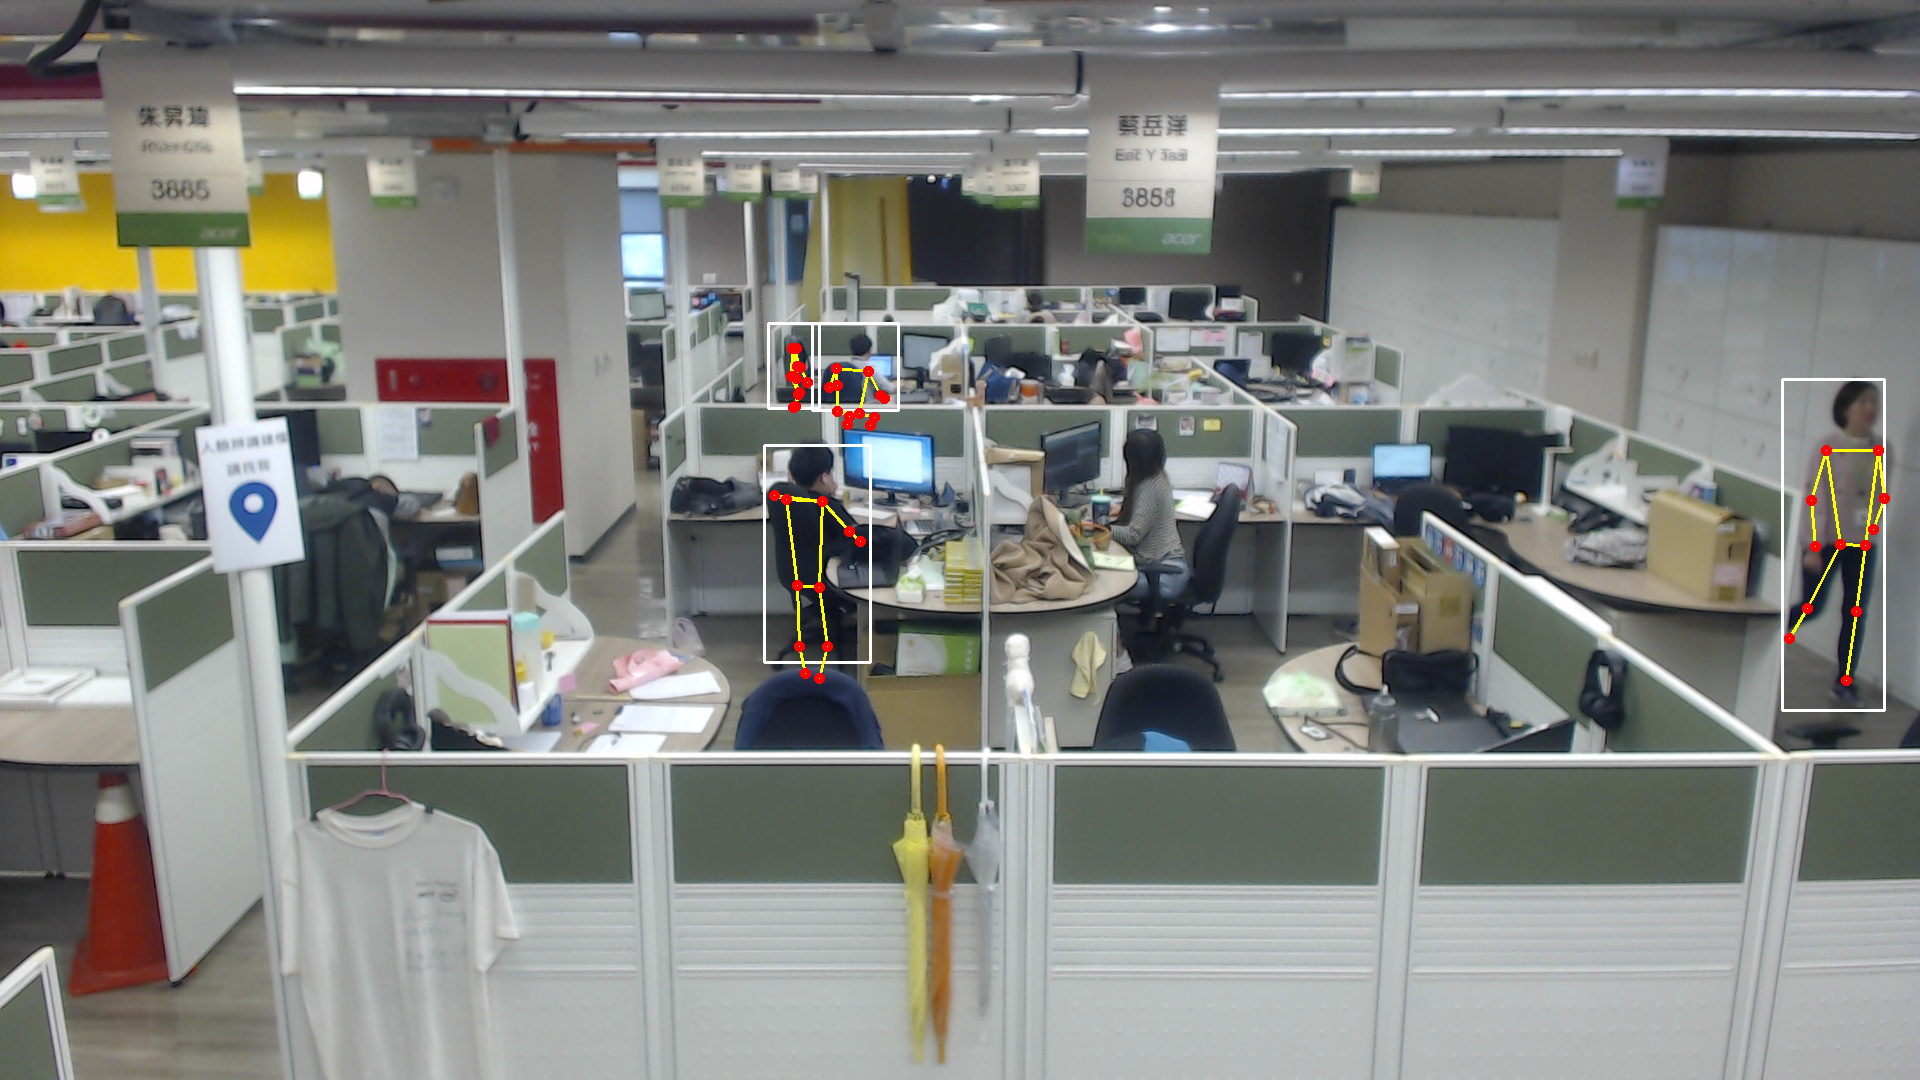

In [123]:
to_pil(np_img)

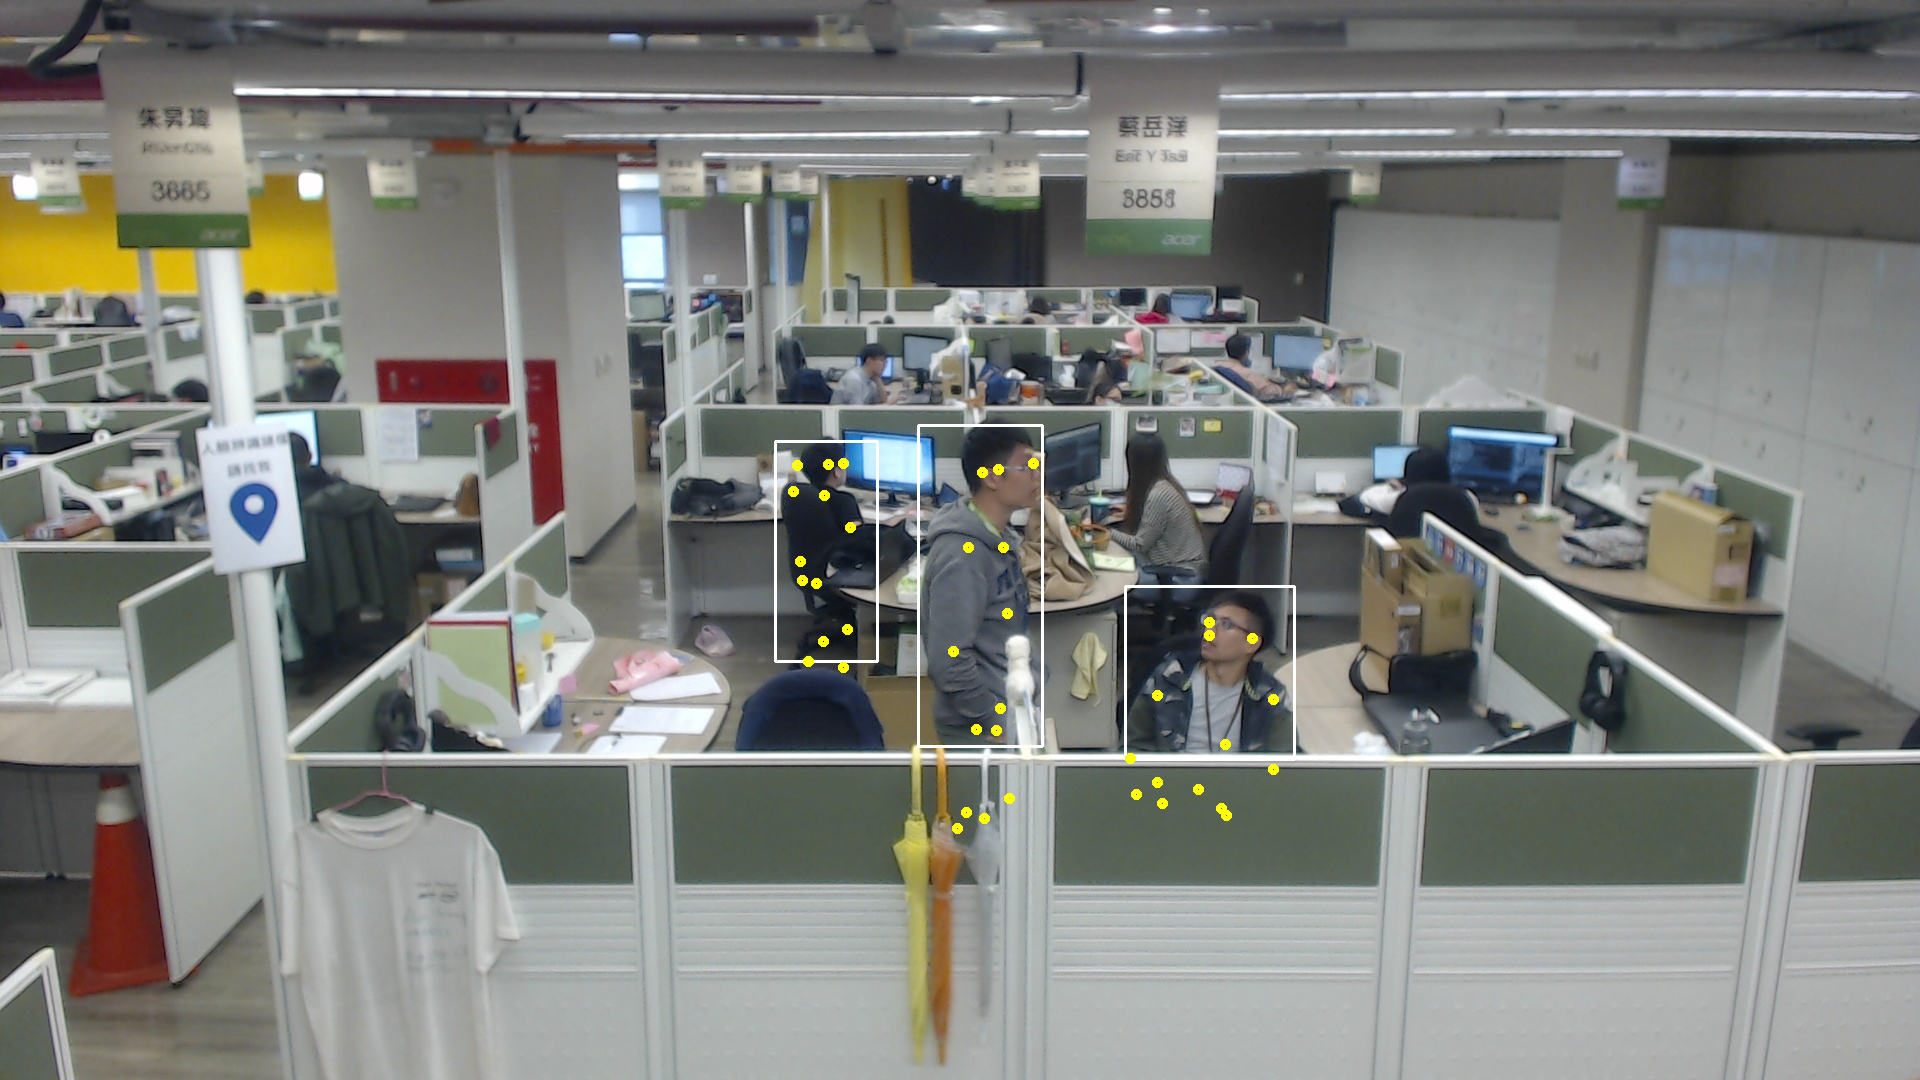

In [35]:
to_pil(np_img)